In [ ]:
from analytic_psfs import Mie_Theory
from analytic_psfs import Plot_Everything
import numpy as np
import matplotlib.pyplot as plt

## Vary Pump Power

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(9.3,1.8),sharex=True)
radius = np.array([10, 20, 30, 40, 50])*1E-7
ax[0].set_xlabel('Pump Wavelength [nm]')

waverange = np.round(np.arange(400, 700, 1)*1E-7, 7)
pump = waverange
probe = 1000.E-7
whichalpha='coreshell_MW'
nTOT_abs=10
nTOT_sca=10
power = 1000 # microWatts

pe = Plot_Everything(radius)
pe.pi_si_terms(pump, probe, whichalpha, nTOT_abs, nTOT_sca, power, fig, ax, plot_self_diff=True, sep_sincos=True)


## Model of Pump Varied

In [ ]:
from scipy.interpolate import interp1d

waverange = np.arange(400,700)*1E-7
radius=np.array([10, 20, 30, 40, 50])*1E-7

waist = waverange * 0.6 / 1.25 
nTOT=10

fig, ax = plt.subplots(1, 5, figsize=(9.3,1.8),sharex=True)

for idx, rad in enumerate(radius):
    mt = Mie_Theory(rad, waverange)
    abs_cross, _, _ = mt.cross_sects(nTOT=nTOT)
    abs_cross_MIE, _, _ = mt.cross_sects(nTOT=nTOT_abs)
    ax[idx].fill_between(waverange*1E7, abs_cross_MIE/max(abs_cross_MIE), 
                     color='gray',zorder=1, alpha=.6)
    idx_abs = np.where(abs_cross_MIE == max(abs_cross_MIE))
    max_abs = waverange[idx_abs]
    ax[idx].plot(np.array([max_abs, max_abs])*1E7, 
        np.array([0, 1]), color='k', linewidth=0.75, linestyle='dashed',zorder=20)    
    
    linear = abs_cross/waist**2
    quad = abs_cross**2/waist**4
    ax[idx].plot(waverange*1E7, linear/max(linear), label='$\sigma_{abs}$/w$^2$',color='lime',zorder=10)
    ax[idx].plot(waverange*1E7, quad/max(quad), label='$\sigma_{abs}$/w$^4$',color='m',zorder=10)
    ax[idx].set_title(str('r = ')+str(int(np.round(rad*1E7)))+str(' nm'))
    ax[idx].set_ylim([0, 1.1])
    ax[idx].set_xlim([400, 700])
plt.subplots_adjust(left=.05, bottom=.2, right=.95, 
                    top=.8, wspace=.5) 
ax[0].set_xlabel('Pump Wavelength [nm]')
fig.savefig(str('pump_model.png'), 
    dpi=500, bbox_inches='tight'
    )


## Vary Probe Wavelength

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(9.3,1.8),sharex=True)
radius = np.array([10, 20, 30, 40, 50])*1E-7

ax[0].set_xlabel('Probe Wavelength [nm]')
waverange = np.round(np.arange(400, 700, 1)*1E-7, 7)
pump = np.array([532.E-7])
probe = waverange
whichalpha='coreshell_MW'
nTOT_abs=10
nTOT_sca=1
power = 500 # microWatts

pe = Plot_Everything(radius)
pe.pi_si_terms(pump, probe, whichalpha, nTOT_abs, nTOT_sca, power, fig, ax, plot_self_diff=True, sep_sincos=True)

## Model of Probe Varied

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

nb=1.473

def eps(wavelength):
    JCdata = np.loadtxt('auJC_interp.tab',skiprows=3)
    wave = JCdata[:,0]*1E-4 # cm
    n_re_raw = JCdata[:,1]
    n_im_raw = JCdata[:,2]
    wavenew = np.arange(np.round(min(wave),7)+1E-7, np.round(max(wave),7), 1E-7)
    f_nre= interp1d(wave, n_re_raw, "cubic")
    n_re = f_nre(wavenew)
    f_nim= interp1d(wave, n_im_raw, "cubic")
    n_im = f_nim(wavenew)
    idx = np.where(np.round(wavenew,7) == np.round(wavelength,7))[0][0]
    n = n_re[idx] + 1j*n_im[idx]
    eps = n_re[idx]**2 - n_im[idx]**2 +1j*(2*n_re[idx]*n_im[idx])
    return eps

def alpha(wavelength, r):
    xi = 2*np.pi*r/wavelength
    q = 1/3*(1-(xi)**2 - 1j*2/3*(xi)**3)
    eps1 = eps(wavelength)
    epsb = nb**2
    return epsb/3*r**3*(eps(wavelength)-nb**2)/( nb**2 +q*(eps(wavelength) - nb**2) )

def pi(wavelength):
    k = 1#2*np.pi*nb/wavelength
    eps1 = eps(wavelength)
    epsb = nb
    return k*np.imag(1/(eps1+2*epsb)**2)

def term1(wavelength):
    k = 1#2*np.pi*nb/wavelength
    eps1 = eps(wavelength)
    epsb = nb
    return k**4*np.real(1/np.conj(eps1+2*epsb) * 1/(eps1+2*epsb)**2)

def term2(wavelength):
    k = 1#2*np.pi*nb/wavelength
    eps1 = eps(wavelength)
    epsb = nb
    return np.real(1/np.abs((eps1+2*epsb)**2)**2)

def scat(wavelength):
    eps1 = eps(wavelength)
    epsb = nb
    return np.real(1/np.abs(eps1+2*epsb))**2

def ext(wavelength):
    eps1 = eps(wavelength)
    epsb = nb
    return np.imag(-1/(eps1+2*epsb))

waverange = np.arange(400,700)*1E-7
termalpha_1 = np.zeros(len(waverange))
termalpha_2 = np.zeros(len(waverange))
pi_term = np.zeros(len(waverange))
sca = np.zeros(len(waverange))
ext_c = np.zeros(len(waverange))

for idx, wave in enumerate(waverange):
    termalpha_1[idx] = term1(wavelength=wave)
    termalpha_2[idx] = term2(wavelength=wave)
    pi_term[idx] = pi(wavelength=wave)
    sca[idx] = scat(wavelength=wave)
    ext_c[idx] = ext(wavelength=wave)

fig, ax = plt.subplots(1, 1, figsize=(4,4),sharex=True)
plt.plot(waverange*1E7, termalpha_1/max(termalpha_1),'green', label=str('SI 1'))
plt.plot(waverange*1E7, termalpha_2/max(termalpha_2), 'orange',label=str('SI 2'))
plt.plot(waverange*1E7, pi_term/max(pi_term), 'blue',label=str('PI'))
plt.plot(waverange*1E7, sca/max(sca), 'k',linestyle='dotted', label=str('Sca'))
plt.plot(waverange*1E7, ext_c/max(ext_c), 'k',linestyle='dashed', label=str('Ext'))

plt.axhline(0, color='k')
idx_1_min = np.where(termalpha_1 == min(termalpha_1))
idx_1_max = np.where(termalpha_1 == max(termalpha_1))
idx_2_min = np.where(termalpha_2 == min(termalpha_2))
idx_2_max = np.where(termalpha_2 == max(termalpha_2))
idx_p_min = np.where(pi_term == min(pi_term))
idx_p_max = np.where(pi_term == max(pi_term))
idx_ext_max = np.where(ext_c == max(ext_c))
idx_sca_max = np.where(sca == max(sca))


print('Min SI1', int(waverange[idx_1_min][0]*1E7))
print('Max SI1', int(waverange[idx_1_max][0]*1E7))

print('Min SI2', int(waverange[idx_2_min][0]*1E7))
print('Max SI2', int(waverange[idx_2_max][0]*1E7))

print('Min PI', int(waverange[idx_p_min][0]*1E7))
print('Max PI', int(waverange[idx_p_max][0]*1E7))

print('Max Sca', int(waverange[idx_sca_max][0]*1E7))
print('Max Ext', int(waverange[idx_ext_max][0]*1E7))

plt.xlim([480, 560])
plt.ylim([0.4, 1.1])
plt.xlabel('Probe Wavelength [nm]')
# plt.legend(frameon=False)
plt.subplots_adjust(bottom=.2)

fig.savefig('check_pols.png',
    dpi=500, bbox_inches='tight'
    )


## Sweep Power

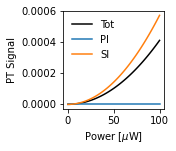

In [9]:
from analytic_psfs import Mie_Theory
from analytic_psfs import Plot_Everything
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(2.,2.),sharex=True)
radius = np.array([10])*1E-7

waverange = np.round(np.arange(400, 700, 1)*1E-7, 7)
pump = np.array([532.E-7])
probe = 785.E-7
whichalpha='glyc_sph_MW'
nTOT_abs=10

          

waist_pr = probe * 0.6 / 1.25
nb_T0 = 1.473
zR = np.pi*waist_pr**2*nb_T0/probe
zp = np.array([0*zR])

power_range = np.arange(0, 101, 1) # microwatts

pe = Plot_Everything(radius,)
pe.sweep_power(pump, probe, whichalpha, 'comp', nTOT_abs, power_range, zp)

fig.savefig('power.png',
    dpi=500, bbox_inches='tight'
    )


## Vary Both Pump and Probe

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(9.3,1.8),sharex=True)
radius = np.array([10, 20, 30, 40, 50])*1E-7
ax[0].set_xlabel('Pump and Probe Wavelength [nm]')

waverange = np.round(np.arange(400, 700, 1)*1E-7, 7)
pump = waverange
probe = waverange
whichalpha='coreshell_MW'
nTOT_abs=10
nTOT_sca=10
power = 500 # microWatts

pe = Plot_Everything(radius)
pe.pi_si_terms(pump, probe, whichalpha, nTOT_abs, nTOT_sca, power, fig, ax, plot_self_diff=True, sep_sincos=True)
